# Check the read in stellar evolutionary tracks formatted by me and the one shared by Ilaria

In [1]:
import numpy as np
import pandas as pd

import os, sys, tqdm, copy, re

import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
import matplotlib

style = [
    'seaborn-ticks',
    {
        'figure.dpi': 300,
        'font.size': 12,
        'image.cmap': 'inferno',
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman'] + plt.rcParams['font.serif'],
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in',
        'mathtext.fontset': 'cm'
        }]
plt.style.use(style)

agepro_dir = '/home/dingshandeng/github/DataCalibration/'
sys.path.append(os.path.join(agepro_dir, 'AGE-PRO-analysis/', 'Image_Plots/'))
import sources as ss

import scipy.io

github_dir = '/home/dingshandeng/github/ysoisochrone/'

os.chdir(os.path.join(github_dir, 'tests'))
sys.path.append(os.path.join(github_dir))
import ysoisochrone.utils as utils
import ysoisochrone.bayesian

#### Load the datafile from Python

In [2]:
# Load the saved .mat file
loaded_data_py = scipy.io.loadmat('./isochrones_data/Feiden_AgeMassGrid_YSO_matrix.mat')
# loaded_data_py = scipy.io.loadmat('./isochrones_data/Feiden_trkP2016_AgeMassGrid_YSO_matrix.mat')
# loaded_data_py = scipy.io.loadmat('./isochrones_data/Feiden_AgeMassGrid_iso_YSO_matrix.mat')

# Access the data
masses_py = loaded_data_py['mass'][0]
log_age_py = loaded_data_py['log_age'][0]
logtlogl_py = loaded_data_py['logt_logl']

In [3]:
loaded_data_py2 = scipy.io.loadmat('./isochrones_data/Feiden_trkP2016_AgeMassGrid_YSO_matrix.mat')

# Access the data
masses_py2 = loaded_data_py2['mass'][0]
log_age_py2 = loaded_data_py2['log_age'][0]
logtlogl_py2 = loaded_data_py2['logt_logl']

#### The datafile from IDL

In [4]:
loaded_data_idl = scipy.io.readsav('./isochrones_data/Feiden_AgeMassGrid.sav')
masses_idl = loaded_data_idl['mass']
log_age_idl = loaded_data_idl['log_age']
logtlogl_idl = loaded_data_idl['logt_logl']

## The function for comparisons

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

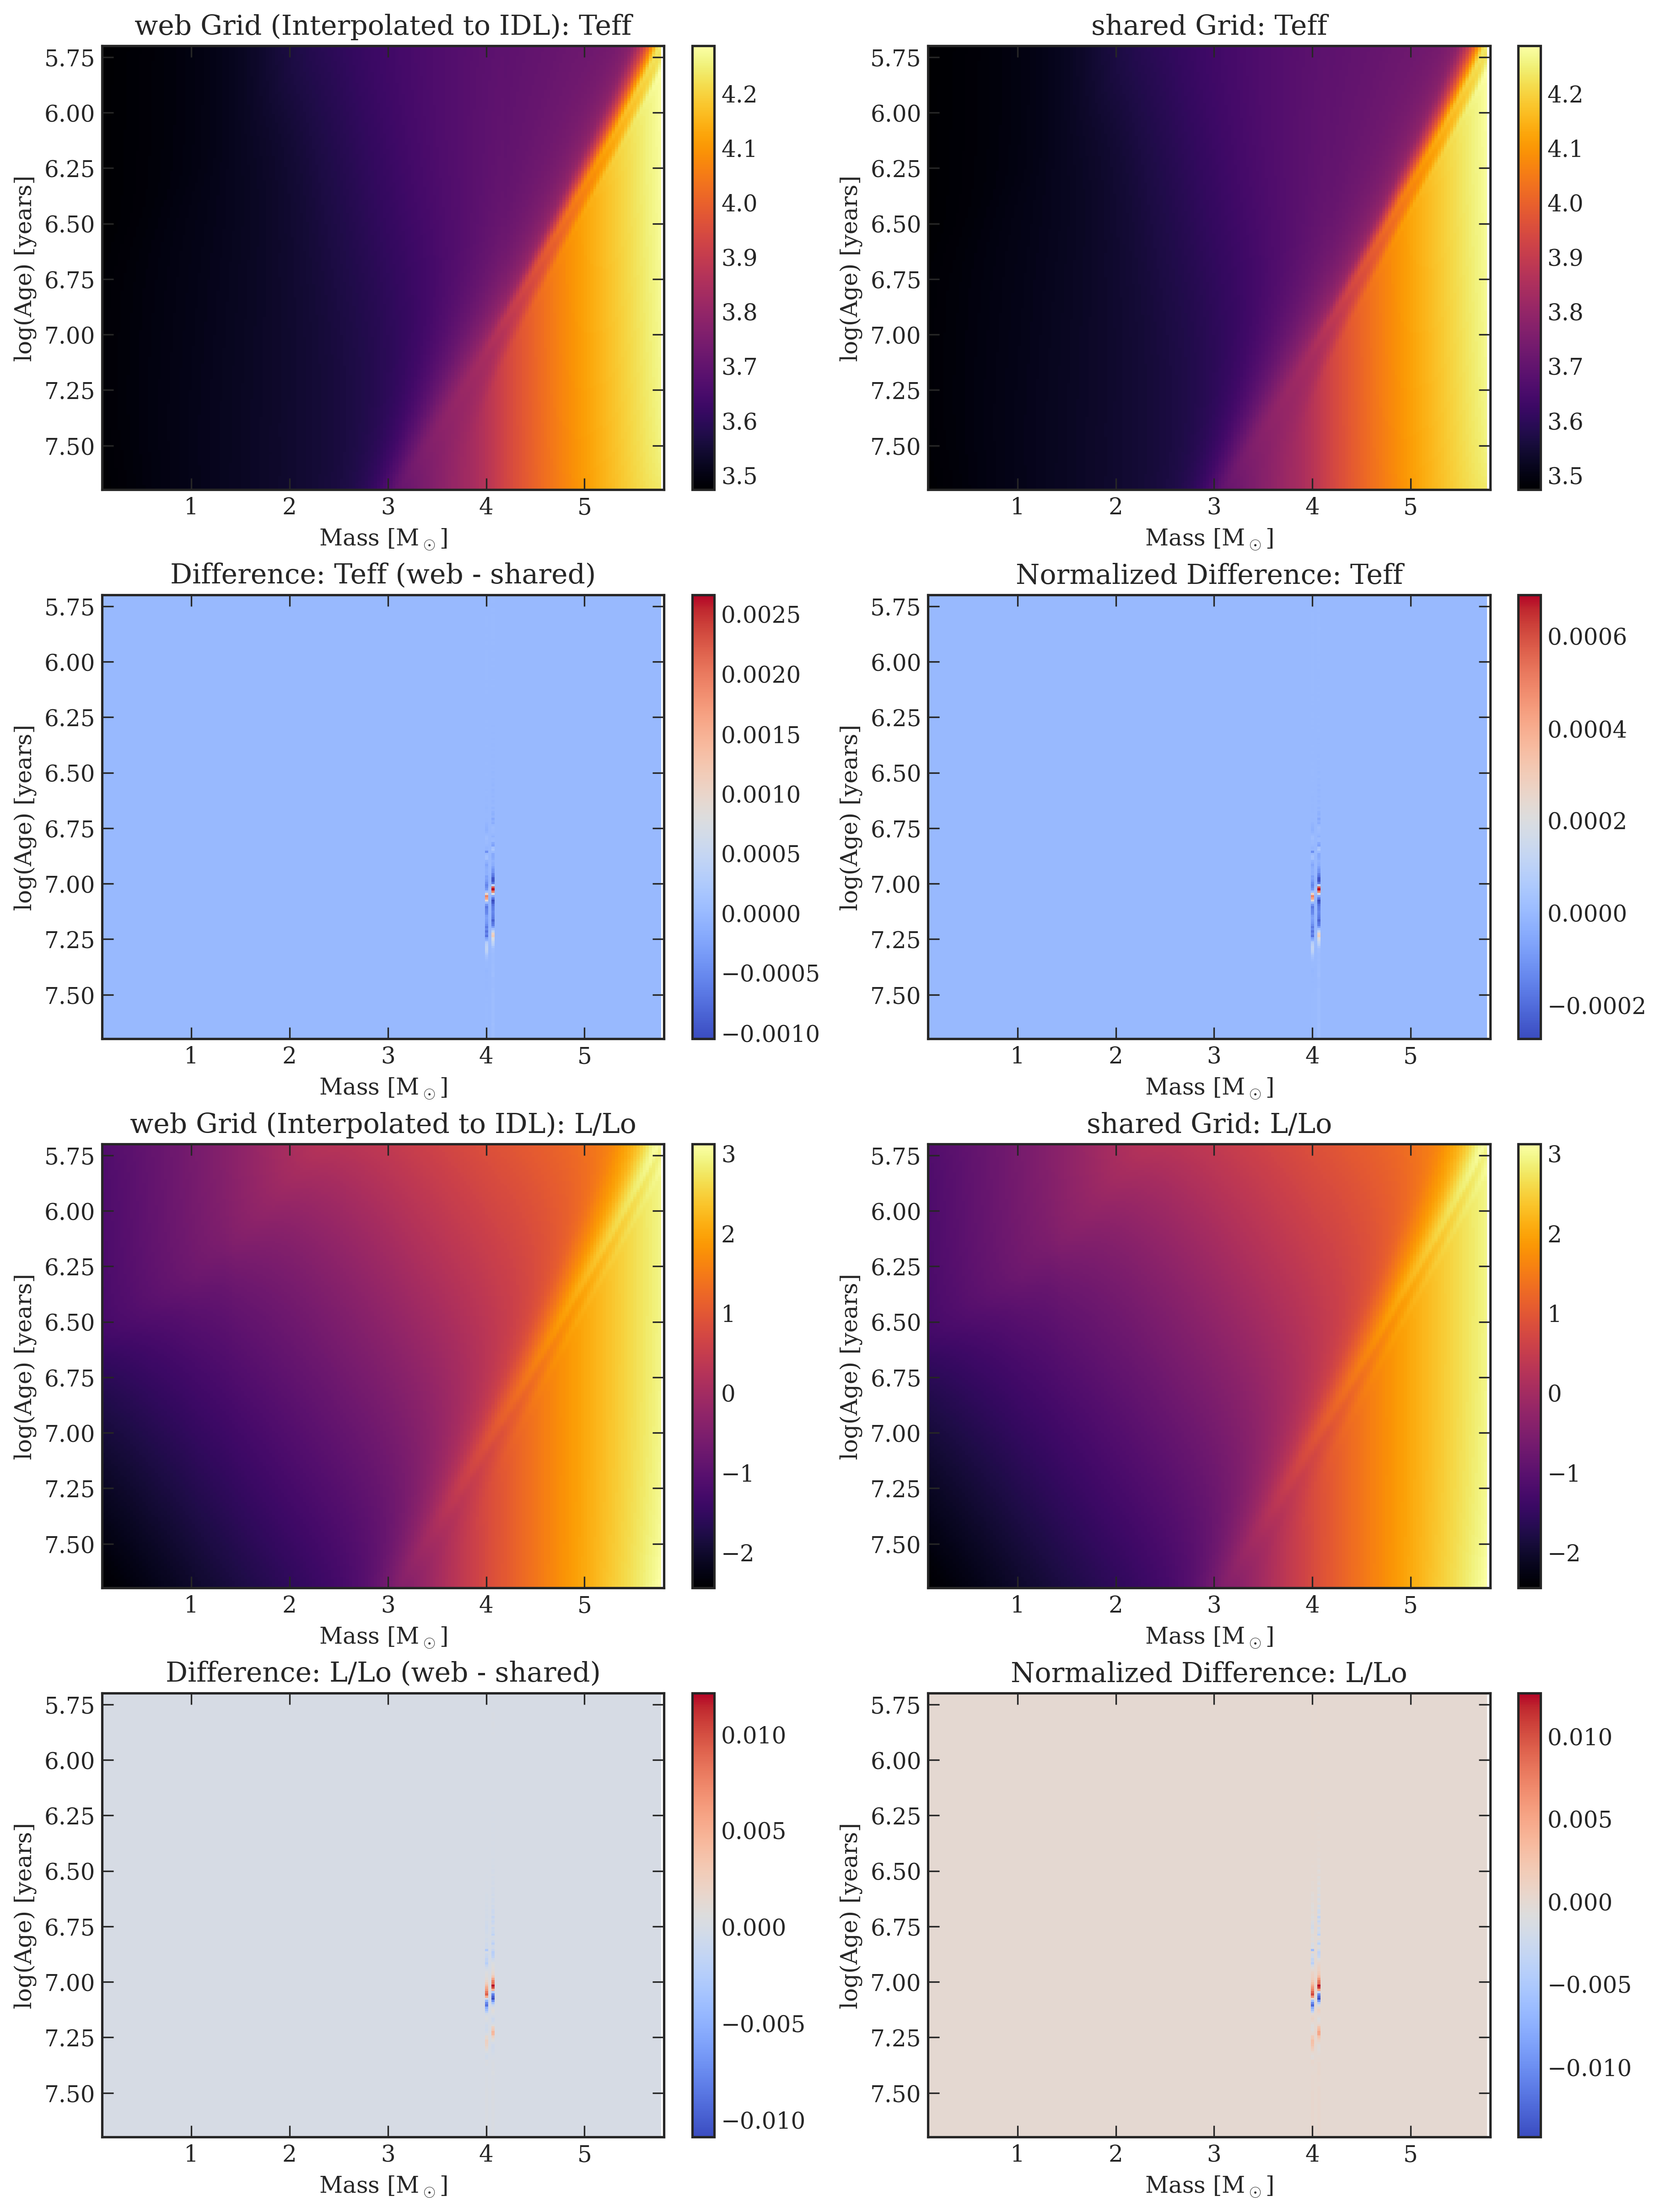

In [6]:
def compare_grids(loaded_data_py, loaded_data_idl, gridnames=['Python', 'IDL']):
    """
    Compares the Python and IDL-generated grids by interpolating the Python grid onto the sparser IDL grid
    and plotting the differences.

    Args:
    ------------
    loaded_data_py: [dict]
        Dictionary containing the Python-generated grid data (masses, log_age, logtlogl).
    loaded_data_idl: [dict]
        Dictionary containing the IDL-generated grid data (masses, log_age, logtlogl).
    gridnames: [list] of strings
        The names of the grid names, default is Python and IDL

    Output:
    ------------
    A visual comparison of the Python and IDL grids with difference and normalized difference plots.
    """
    
    # Load data from Python
    masses_py = loaded_data_py['mass'][0]
    log_age_py = loaded_data_py['log_age'][0]
    logtlogl_py = loaded_data_py['logt_logl']  # Shape: [n_log_age, n_mass, 2] for Teff and L/Lo

    # Load data from IDL
    masses_idl = loaded_data_idl['mass']
    log_age_idl = loaded_data_idl['log_age']
    logtlogl_idl = loaded_data_idl['logt_logl']  # Shape: [n_log_age, n_mass, 2] for Teff and L/Lo

    # Interpolation: First, create the grid to interpolate Python data onto the IDL grid
    grid_idl = np.array(np.meshgrid(log_age_idl, masses_idl)).T.reshape(-1, 2)
    
    # Interpolate Python logtlogl data onto the IDL grid
    logtlogl_interp_py = np.zeros_like(logtlogl_idl)

    for i in range(2):  # For both Teff and L/Lo
        points_py = np.array(np.meshgrid(log_age_py, masses_py)).T.reshape(-1, 2)
        values_py = logtlogl_py[:, :, i].flatten()
        
        # Use griddata to interpolate Python logtlogl onto the IDL grid
        logtlogl_interp_py[:, :, i] = griddata(points_py, values_py, grid_idl).reshape(logtlogl_idl.shape[0], logtlogl_idl.shape[1])

    # Calculate the differences between the interpolated Python data and IDL data
    logtlogl_diff = logtlogl_interp_py - logtlogl_idl

    # Calculate the normalized differences (relative differences)
    logtlogl_diff_norm = logtlogl_diff / logtlogl_interp_py

    # Plot the results
    plot_comparison(log_age_idl, masses_idl, logtlogl_interp_py, logtlogl_idl, logtlogl_diff, logtlogl_diff_norm, gridnames)


def plot_comparison(log_age_idl, masses_idl, logtlogl_interp_py, logtlogl_idl, logtlogl_diff, logtlogl_diff_norm, gridnames=['Python', 'IDL']):
    """
    Plots the Python grid (interpolated onto IDL grid), IDL grid, and their differences for both Teff and L/Lo.

    Args:
    ------------
    log_age_idl: [array]
        Array of log(age) values from the IDL grid.
    masses_idl: [array]
        Array of mass values from the IDL grid.
    logtlogl_interp_py: [array]
        Python-generated logtlogl data (Teff and L/Lo) interpolated onto the IDL grid.
    logtlogl_idl: [array]
        IDL-generated logtlogl data (Teff and L/Lo).
    logtlogl_diff: [array]
        Difference between interpolated Python and IDL logtlogl data.
    logtlogl_diff_norm: [array]
        Normalized difference between interpolated Python and IDL logtlogl data.
    gridnames: [list] of strings
        The names of the grid names, default is Python and IDL
    """
    
    fig, axs = plt.subplots(4, 2, figsize=(12, 16), constrained_layout=True)

    # Set the extent of the grid to match the IDL grid
    extent = [masses_idl.min(), masses_idl.max(), log_age_idl.max(), log_age_idl.min()]

    # Teff Plot (Interpolated Python Grid)
    im1 = axs[0, 0].imshow(logtlogl_interp_py[:, :, 0], aspect='auto', extent=extent)
    axs[0, 0].set_title('%s Grid (Interpolated to IDL): Teff'%(gridnames[0]))
    axs[0, 0].set_xlabel('Mass [M$_\odot$]')
    axs[0, 0].set_ylabel('log(Age) [years]')
    fig.colorbar(im1, ax=axs[0, 0])

    # Teff Plot (IDL Grid)
    im2 = axs[0, 1].imshow(logtlogl_idl[:, :, 0], aspect='auto', extent=extent)
    axs[0, 1].set_title('%s Grid: Teff'%(gridnames[1]))
    axs[0, 1].set_xlabel('Mass [M$_\odot$]')
    axs[0, 1].set_ylabel('log(Age) [years]')
    fig.colorbar(im2, ax=axs[0, 1])

    # Teff Difference Plot
    im3 = axs[1, 0].imshow(logtlogl_diff[:, :, 0], aspect='auto', cmap='coolwarm', extent=extent)
    axs[1, 0].set_title('Difference: Teff (%s - %s)'%(gridnames[0], gridnames[1]))
    axs[1, 0].set_xlabel('Mass [M$_\odot$]')
    axs[1, 0].set_ylabel('log(Age) [years]')
    fig.colorbar(im3, ax=axs[1, 0])

    # Teff Normalized Difference Plot
    im4 = axs[1, 1].imshow(logtlogl_diff_norm[:, :, 0], aspect='auto', cmap='coolwarm', extent=extent)
    axs[1, 1].set_title('Normalized Difference: Teff')
    axs[1, 1].set_xlabel('Mass [M$_\odot$]')
    axs[1, 1].set_ylabel('log(Age) [years]')
    fig.colorbar(im4, ax=axs[1, 1])

    # L/Lo Plot (Interpolated Python Grid)
    im5 = axs[2, 0].imshow(logtlogl_interp_py[:, :, 1], aspect='auto', extent=extent)
    axs[2, 0].set_title('%s Grid (Interpolated to IDL): L/Lo'%(gridnames[0]))
    axs[2, 0].set_xlabel('Mass [M$_\odot$]')
    axs[2, 0].set_ylabel('log(Age) [years]')
    fig.colorbar(im5, ax=axs[2, 0])

    # L/Lo Plot (IDL Grid)
    im6 = axs[2, 1].imshow(logtlogl_idl[:, :, 1], aspect='auto', extent=extent)
    axs[2, 1].set_title('%s Grid: L/Lo'%(gridnames[1]))
    axs[2, 1].set_xlabel('Mass [M$_\odot$]')
    axs[2, 1].set_ylabel('log(Age) [years]')
    fig.colorbar(im6, ax=axs[2, 1])

    # L/Lo Difference Plot
    im7 = axs[3, 0].imshow(logtlogl_diff[:, :, 1], aspect='auto', cmap='coolwarm', extent=extent)
    axs[3, 0].set_title('Difference: L/Lo (%s - %s)'%(gridnames[0], gridnames[1]))
    axs[3, 0].set_xlabel('Mass [M$_\odot$]')
    axs[3, 0].set_ylabel('log(Age) [years]')
    fig.colorbar(im7, ax=axs[3, 0])

    # L/Lo Normalized Difference Plot
    im8 = axs[3, 1].imshow(logtlogl_diff_norm[:, :, 1], aspect='auto', cmap='coolwarm', extent=extent)
    axs[3, 1].set_title('Normalized Difference: L/Lo')
    axs[3, 1].set_xlabel('Mass [M$_\odot$]')
    axs[3, 1].set_ylabel('log(Age) [years]')
    fig.colorbar(im8, ax=axs[3, 1])

    plt.show()

# Example usage
# loaded_data_py = scipy.io.loadmat('./isochrones_data/Feiden_trkP2016_AgeMassGrid_YSO_matrix.mat')
# loaded_data_idl = scipy.io.readsav('./isochrones_data/Feiden_AgeMassGrid.sav')

# Compare the grids
# compare_grids(loaded_data_py, loaded_data_idl)
compare_grids(loaded_data_py, loaded_data_py2, gridnames=['web', 'shared'])